In [112]:
import os
import sys
import cartopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.lines import Line2D
from datetime import datetime
from cartopy import crs as ccrs
import cartopy.io.img_tiles as cimgt 

In [113]:
# Variable Selection
date_selection = '2024-05-05'
area = {
    'US':[-128,-65,22,52]
    }
region = 'US'
set_extent = area.get(region)
root_folder = f'{os.path.dirname(sys.path[0])}/data/get_states/{date_selection}'

In [114]:
def read_csv(root_folder,csv_file):
    df = pd.read_csv(f'{root_folder}/csv/{csv_file}') 
    df = df[df['on_ground'] == False] #Excluding Taxiing Aircraft
    df['x_speed'] = np.sin(np.deg2rad(df['true_track']))*df['velocity']
    df['y_speed'] = np.cos(np.deg2rad(df['true_track']))*df['velocity']
    df_aircraft = [(x,y,u,v,speed,country) for x,y,u,v,speed,country in zip(df['longitude'],df['latitude'],df['x_speed'],df['y_speed'],df['velocity'],df['origin_country'])]
    return df_aircraft

In [115]:
def map_tile_request():
    with open(f'/home/filpill/work/flight_tracking/scripts/keys/stadiamaps.key', 'r') as f:
        creds = f.read().strip().split(' ')
        API_KEY = creds[0]
    os.environ['API_KEY'] = API_KEY
    map_tile = cimgt.StadiaMapsTiles(apikey=API_KEY,style='alidade_smooth_dark',resolution="@2x") 
    return map_tile 
map_tile = map_tile_request()

In [122]:
def base_chart(map_tile,set_extent):
    
    # Figure Size, Chart Elements and Geographic Coordinate Projection
    fig = plt.figure(figsize =(16,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.text(
        x=0.00675,
        y=0.0545,
        s='Created By Filip Livancic', 
        transform=ax.transAxes, 
        bbox=dict(facecolor='white',alpha=0.65), 
        va='bottom',
        ha='left', 
        fontsize=7
    )
    
    ax.text(
        x=0.00675,
        y=0.0145,
        s='Map Data: ©Stadia Maps ©OpenMapTiles ©OpenStreetMap', 
        transform=ax.transAxes, 
        bbox=dict(facecolor='white',alpha=0.65), 
        va='bottom',
        ha='left', 
        fontsize=7
    )

    # List available styles in a Dictionary
    map_styles = {
        1:'default',
        2:'alidade-dark'
    }
    map_select = map_styles.get(2)

    # Logic to Draw the map selected from Dictionary
    if map_select == 'default':
        ax.add_feature(cartopy.feature.LAND)
        ax.add_feature(cartopy.feature.OCEAN)
        ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
        ax.add_feature(cartopy.feature.BORDERS,linestyle='-',linewidth=0.3)
        ax.add_feature(cartopy.feature.LAKES,alpha=0.5)
        ax.add_feature(cartopy.feature.RIVERS,alpha=0.5)
        ax.coastlines()
        ax.stock_img()
        ax.set_extent(set_extent, crs=ccrs.PlateCarree()) 
    elif map_select == 'alidade-dark':
        ax.add_image(map_tile,6,interpolation='spline36')

    return fig, ax

In [123]:
def filter_data_boundary(df_aircraft,set_extent):
    # Filtering Data To Desired Airspace Boundary
    df_aircraft = pd.DataFrame(df_aircraft,columns=['x','y','u','v','speed','country'])
    df_aircraft_filtered = df_aircraft[
                                      (df_aircraft['x']>=set_extent[0]) &
                                      (df_aircraft['x']<=set_extent[1]) &
                                      (df_aircraft['y']>=set_extent[2]) &
                                      (df_aircraft['y']<=set_extent[3])
                                    ] 
    return df_aircraft_filtered

In [124]:
def calculate_KDE(df_aircraft_filtered):
   # Calculating Gaussian KDE Based on x,y Coordinates
    xy = np.vstack([df_aircraft_filtered['x'],df_aircraft_filtered['y']])
    kde = gaussian_kde(xy)
    density = kde(xy) 
    return density

In [125]:
def plot_scatter_points(
        df_aircraft_filtered,
        root_folder,
        timestamp,
        density,
        region,
        fig,
        ax
    ):
    fig=fig
    ax=ax
    # Plot new scatter points and title - save figure
    scatter = ax.scatter(
        df_aircraft_filtered['x'],
        df_aircraft_filtered['y'],
        c=density, 
        cmap='afmhot', 
        transform=ccrs.PlateCarree(),
        s=6,
        norm=LogNorm()
    ) 
    title = ax.set_title(
        f'OpenSky Network API | Aircraft Tracking - {region} Region | {timestamp}',
        loc='left', 
        fontsize=10
    )
    ax.figure.savefig(f'{root_folder}/scatter/{timestamp}.png', format='png', dpi=200)

    # Clear scatter before returning plot back to main script
    scatter.remove()
    return fig,ax

In [126]:
def extract_timestamp(csv_file):
    timestamp = csv_file.split('.')[0]
    timestamp = datetime.strptime(timestamp,'%Y-%m-%dT%H:%M:%S')
    timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S UTC')
    return timestamp

Creating Image from: 2024-05-05T20:14:36.539206.csv
Creating Image from: 2024-05-05T20:15:38.577825.csv
Creating Image from: 2024-05-05T20:16:40.377785.csv
Creating Image from: 2024-05-05T20:17:42.192539.csv
Creating Image from: 2024-05-05T20:18:43.751990.csv
Creating Image from: 2024-05-05T20:19:45.204410.csv
Creating Image from: 2024-05-05T20:20:49.604984.csv
Creating Image from: 2024-05-05T20:21:51.412865.csv
Creating Image from: 2024-05-05T20:22:53.423664.csv
Creating Image from: 2024-05-05T20:23:55.012803.csv
Creating Image from: 2024-05-05T20:24:56.335714.csv
Creating Image from: 2024-05-05T20:25:58.945417.csv
Creating Image from: 2024-05-05T20:27:00.336425.csv
Creating Image from: 2024-05-05T20:28:03.699792.csv
Creating Image from: 2024-05-05T20:29:06.833415.csv
Creating Image from: 2024-05-05T20:30:09.471407.csv
Creating Image from: 2024-05-05T20:31:14.980330.csv
Creating Image from: 2024-05-05T20:32:16.639509.csv
Creating Image from: 2024-05-05T20:33:18.279394.csv
Creating Ima

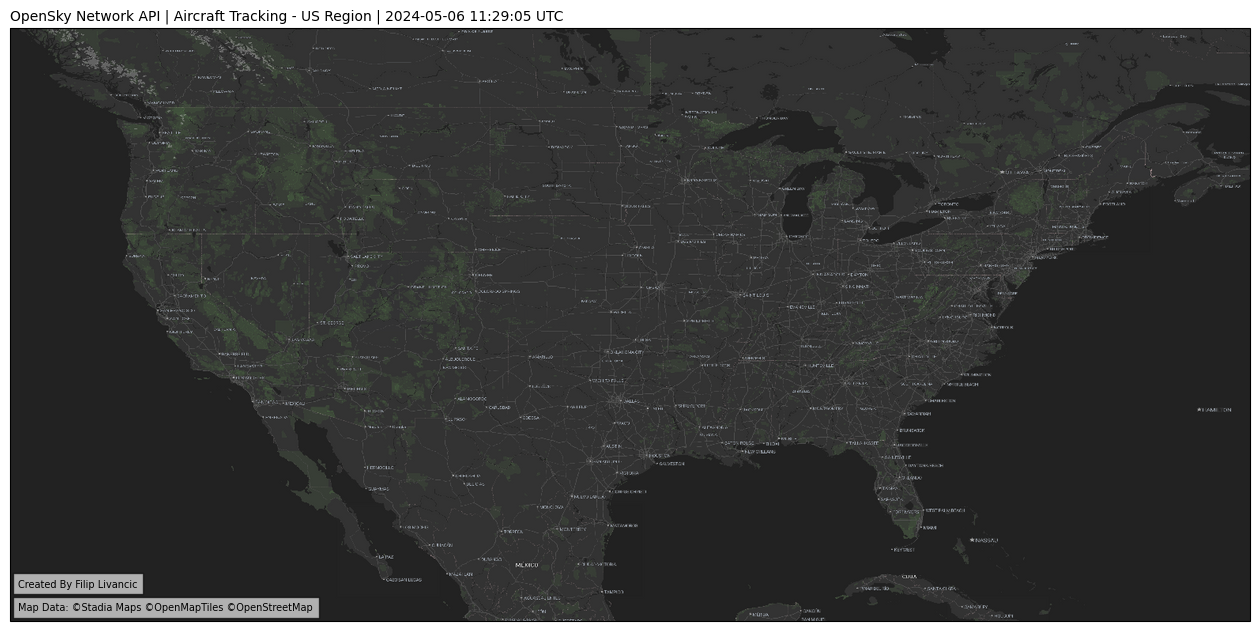

In [127]:
# Create Base Chart with only Map and No Datapoints
fig, ax = base_chart(map_tile,set_extent)
# Looping Through Each CSV, Plotting Scatterpoints And Saving Chart
for csv_file in sorted(os.listdir(f'{root_folder}/csv')):
    print(f'Creating Image from: {csv_file}')
    timestamp = extract_timestamp(csv_file)
    df_aircraft = read_csv(root_folder,csv_file)
    df_aircraft_filtered = filter_data_boundary(df_aircraft,set_extent)
    density = calculate_KDE(df_aircraft_filtered)
    fig, ax = plot_scatter_points(
        df_aircraft_filtered,
        root_folder,
        timestamp,
        density,
        region,
        fig,
        ax
    )